TODO:
1) EDA
2) Run some training script (ready opensource solution)
3) Analyse results (confusion matrix, some exact cases)

In [ ]:
!pip install -U -r ./requirements.txt

In [ ]:
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    BatchEncoding,
    set_seed,
)
import torch
import random

In [ ]:
def set_all_seeds(seed: int):
    random.seed(seed)  # Python random seed
    np.random.seed(seed)  # NumPy random seed
    torch.manual_seed(seed)  # PyTorch CPU seed
    torch.cuda.manual_seed(seed)  # PyTorch CUDA seed
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = (
        True  # Ensure deterministic computation in cuDNN
    )
    torch.backends.cudnn.benchmark = (
        False  # Disable cuDNN auto-tuner for reproducibility
    )
    set_seed(seed)  # Hugging Face transformers seed setting


set_all_seeds(1337)

In [60]:
ds = load_dataset("ramybaly/conll2012")

In [ ]:
LABEL_NAMES = [
    "O",
    "B-CARDINAL",  # количиственные числительные: three, 200, one million, ...
    "B-DATE",  # даты
    "B-EVENT",  # события: Olympic games, Easter, ...
    "B-FAC",  # сооружения (facilities): Eiffel Tower, JFK airport, ...
    "B-GPE",  # геополитические образования: New York, Texas, ...
    "B-LANGUAGE",  # языки: English, French, ...
    "B-LAW",  # законы и нормативные акты: Constitution, Civil Rights Act, ...
    "B-LOC",  # географические локации: Mount Everest, Nile River, ...
    "B-MONEY",  # денежные выражения: $5, 10 euros, five million rubles
    "B-NORP",  # национальности, религии, политические группы: Russians, Buddhists, Republicans, ...
    "B-ORDINAL",  # порядковые числительные: first, second, third, ...
    "B-ORG",  # организации: Google, United Nations, ...
    "B-PERCENT",  # проценты: 50%, twenty percent
    "B-PERSON",  # имена людей: David Lynch, Maxim Kats, ...
    "B-PRODUCT",  # продукты и бренды: Coca-Cola, Iphone, ...
    "B-QUANTITY",  # измеряемые величины с единицами: 5kg, 10 meters, ...
    "B-TIME",  # время: 2 a.m., morning, ...
    "B-WORK_OF_ART",  # произведения искусства: Mona Lisa, Воронины, ...
    "I-CARDINAL",
    "I-DATE",
    "I-EVENT",
    "I-FAC",
    "I-GPE",
    "I-LANGUAGE",
    "I-LAW",
    "I-LOC",
    "I-MONEY",
    "I-NORP",
    "I-ORDINAL",
    "I-ORG",
    "I-PERCENT",
    "I-PERSON",
    "I-PRODUCT",
    "I-QUANTITY",
    "I-TIME",
    "I-WORK_OF_ART",
]

ENTITY_MAPPING = {i: ent for i, ent in enumerate(LABEL_NAMES)}

In [63]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 115812
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 15680
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 12217
    })
})

In [64]:
ds_train = ds["train"].remove_columns(["id", "pos_tags"])
ds_val = ds["validation"].remove_columns(["id", "pos_tags"])
ds_test = ds["test"].remove_columns(["id", "pos_tags"])

df_train = ds_train.to_pandas()
df_val = ds_val.to_pandas()
df_test = ds_test.to_pandas()

In [65]:
df_train

,tokens,tags
0,"[Big, Managers, on, Campus]","[0, 0, 0, 0]"
1,"[In, recent, years, ,, advanced, education, fo...","[0, 2, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[With, this, trend, ,, suddenly, the, mature, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[In, order, to, attract, this, group, of, seas...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 27, 27..."
4,"[In, response, ,, each, year, over, 1000, matu...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
115807,"[In, fact, ,, Iraq, has, almost, sunk, into, a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
115808,"[The, same, day, ,, the, US, National, Broadca...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
115809,"[Analysts, here, have, pointed, out, that, Ann...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
115810,"[Calls, from, within, the, US, for, the, withd...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
idx = 6
dict(
    zip(
        df_train.iloc[idx]["tokens"],
        [ENTITY_MAPPING[klass] for klass in df_train.iloc[idx]["tags"]],
    )
)

{'What': 'O',
 'knowledge': 'O',
 'do': 'O',
 'they': 'O',
 'seek': 'O',
 'that': 'O',
 'can': 'O',
 'not': 'O',
 'be': 'O',
 'found': 'O',
 'in': 'O',
 'society': 'O',
 'at': 'O',
 'large': 'O',
 '?': 'O'}

### Модель


Для задачи подходит декодерная модель BERT с двунаправленным attention-механизмом.
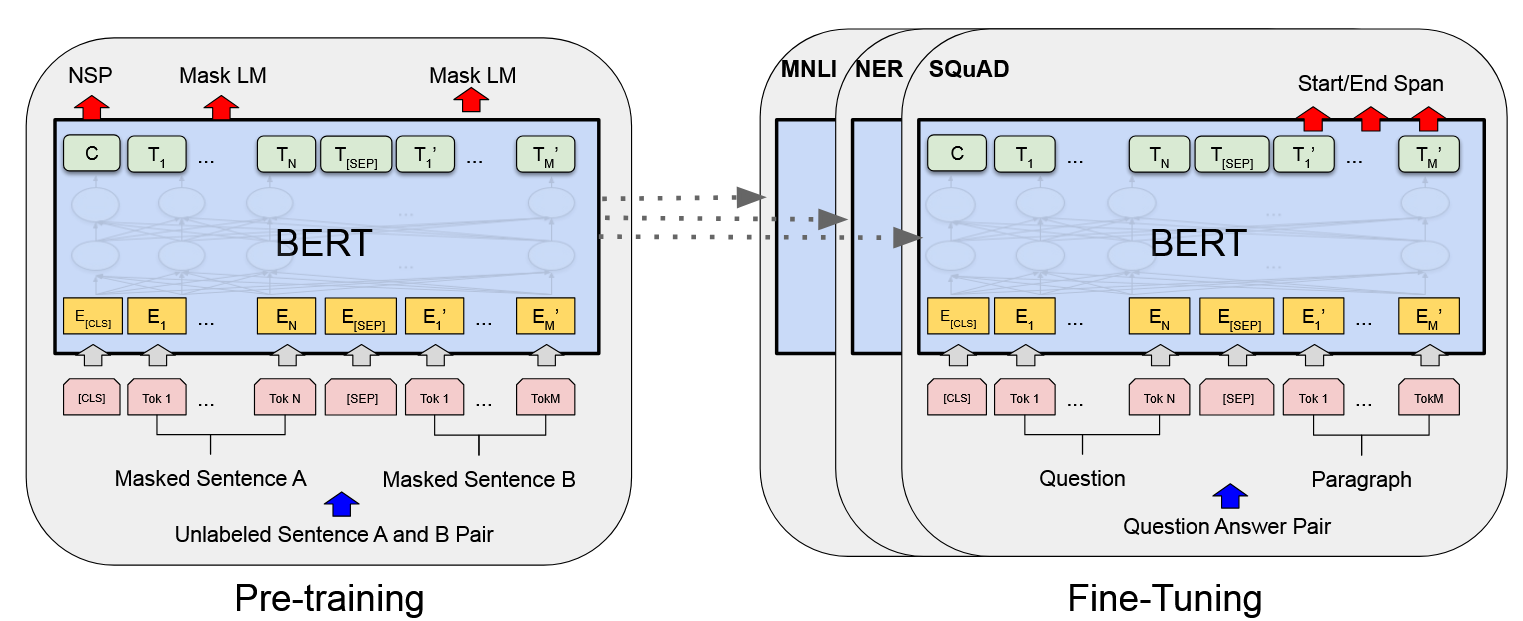
В пайплайне применяется предобученная модель BERT, self-supervised задача на претренировке состоит из 2 частей - $MLM^1$ и $NSP^2$:


1. 15% процентов токенов маскируются, то есть заменяются на [MASK] 
2. Бинарный обджектив-индиктор, являются для заколлейченых в 1 сэмпл преложения реально последовательно встречающимися в тексте.

NER-задача сводится к классификации каждого токена, что означает, что больше подходит дискриминативная модель, ей и является BERT; специфика NER задачи также требует cased-токенизации, так как потенциально поможет в некоторых случаях определить собственные имена.

EDA датасета показывает оценку длины в словах, BPE, как subword метод, увеличивает длину после токенизации; распространенной оценкой является $|text|_{words}\approx 0.75 \times |text|_{BPE-tokens}$ 

In [ ]:
MODEL_NAME = "bert-base-cased"
MAX_LENGTH = 256
BATCH_SIZE = 32
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5

In [68]:
ds_full = dataset = DatasetDict(
    {"train": ds_train, "validation": ds_val, "test": ds_test}
)

In [69]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [70]:
label2id = {label: i for i, label in enumerate(LABEL_NAMES)}
id2label = {i: label for i, label in enumerate(LABEL_NAMES)}

In [71]:
def tokenize_and_align_labels(examples):
    """
    Токенизация текста и выравнивание меток с учетом разделения на подтокены
    """
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding=False,
        is_split_into_words=True,
        max_length=MAX_LENGTH,
        return_tensors=None,  # Будем возвращать списки, а не тензоры
    )

    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            # Специальные токены получают метку -100
            if word_idx is None:
                label_ids.append(-100)
            # Для первого токена каждого слова используем соответствующую метку
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # Для подтокенов используем метку -100 или метку текущего слова (в зависимости от задачи)
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [72]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/12217 [00:00<?, ? examples/s]

In [73]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True)

In [75]:
metric = evaluate.load("seqeval")

In [76]:
def compute_metrics(p):
    """
    Вычисление метрик (precision, recall, f1) для NER
    """
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Убираем специальные токены (метка -100)
    true_predictions = [
        [LABEL_NAMES[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [LABEL_NAMES[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./ner-model",
    evaluation_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    push_to_hub=False,
    report_to=None,
    load_best_model_at_end=True,
)

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import wandb
import os

os.environ["WANDB_DISABLED"] = "false"
wandb.init(mode="disabled")

In [79]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1146666687.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [80]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.073300,0.072657,0.825007,0.883637,0.853316,0.976374
2,0.048000,0.069982,0.844268,0.891064,0.867035,0.978892
3,0.031200,0.071889,0.859541,0.886342,0.872736,0.979486


TrainOutput(global_step=10860, training_loss=0.06334809168048107, metrics={'train_runtime': 4299.0469, 'train_samples_per_second': 80.817, 'train_steps_per_second': 2.526, 'total_flos': 1.1873169212664288e+16, 'train_loss': 0.06334809168048107, 'epoch': 3.0})

In [81]:
trainer.save_model("./ner-final-model")

In [82]:
predictions = trainer.predict(tokenized_datasets["validation"])

In [83]:
print(predictions.metrics)

{'test_loss': 0.06998191028833389, 'test_precision': 0.8442684063373719, 'test_recall': 0.8910637879309496, 'test_f1': 0.8670351494269375, 'test_accuracy': 0.9788921497180149, 'test_runtime': 63.6906, 'test_samples_per_second': 246.19, 'test_steps_per_second': 7.693}


In [84]:
for batch in trainer.get_eval_dataloader():
    break

# Отправляем батч в модель (предполагается, что модель уже натренирована)
model.eval()
with torch.no_grad():
    outputs = model(batch["input_ids"].to(trainer.args.device))

# Получаем предсказанные метки (индексы классов с наибольшей вероятностью)
predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
input_ids = batch["input_ids"].cpu().numpy()
labels = batch["labels"].cpu().numpy()

# Выводим первые несколько примеров из батча
for i in range(3):
    print(f"\n--- Пример {i+1} ---")
    # Декодируем токены обратно в слова, пропуская специальные токены
    tokens = tokenizer.convert_ids_to_tokens(input_ids[i], skip_special_tokens=False)
    pred_tags = [LABEL_NAMES[p] if p != -100 else "O" for p in predictions[i]]
    true_tags = [LABEL_NAMES[l] if l != -100 else "O" for l in labels[i]]

    # Красиво выводим результат
    for token, pred, true in zip(tokens, pred_tags, true_tags):
        print(f"{token:15} | {true:15} | {pred:15}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.



--- Пример 1 ---
[CLS]           | O               | O              
President       | B-WORK_OF_ART   | O              
Chen            | I-WORK_OF_ART   | B-PERSON       
Travel          | I-WORK_OF_ART   | O              
##s             | O               | O              
A               | I-WORK_OF_ART   | O              
##bro           | O               | O              
##ad            | O               | O              
[SEP]           | O               | O              
[PAD]           | O               | O              
[PAD]           | O               | O              
[PAD]           | O               | O              
[PAD]           | O               | O              
[PAD]           | O               | O              
[PAD]           | O               | O              
[PAD]           | O               | O              
[PAD]           | O               | O              
[PAD]           | O               | O              
[PAD]           | O               | O         

In [85]:
predictions = trainer.predict(tokenized_datasets["validation"])

In [86]:
def convert_predictions_simple(original_dataset, predictions, label_names):
    """
    Упрощенная версия - работает напрямую с исходными словами
    """
    word_level_predictions = []
    word_level_true_labels = []

    predicted_labels = np.argmax(predictions.predictions, axis=2)

    for i in range(len(original_dataset)):
        original_tokens = original_dataset[i]["tokens"]
        original_tags = original_dataset[i]["tags"]

        # Для каждого предложения заново токенизируем и находим соответствия
        encoded = tokenizer(
            original_tokens,
            is_split_into_words=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_offsets_mapping=False,
        )

        word_predictions = []
        word_true_labels = [label_names[tag] for tag in original_tags]

        # Проходим по каждому слову и находим его первый токен
        word_ids = []
        for word_idx in range(len(original_tokens)):
            # Находим позицию первого токена для этого слова
            found = False
            for token_idx, token_word_idx in enumerate(encoded.word_ids()):
                if token_word_idx == word_idx:
                    # Это первый токен слова - берем его предсказание
                    if token_idx < len(predicted_labels[i]):
                        word_predictions.append(
                            label_names[predicted_labels[i][token_idx]]
                        )
                    else:
                        word_predictions.append("O")
                    found = True
                    break
            if not found:
                word_predictions.append("O")  # Слово было обрезано

        word_level_predictions.append(word_predictions)
        word_level_true_labels.append(word_true_labels)

    return word_level_predictions, word_level_true_labels


# Используем упрощенную версию - она надежнее
print("Конвертируем предсказания...")
all_word_predictions, all_word_true_labels = convert_predictions_simple(
    ds_val, predictions, LABEL_NAMES
)

print(f"Обработано {len(all_word_predictions)} предложений")
print(f"Пример предсказаний: {all_word_predictions[0]}")
print(f"Пример истинных меток: {all_word_true_labels[0]}")

Конвертируем предсказания...
Обработано 15680 предложений
Пример предсказаний: ['O', 'B-PERSON', 'I-ORG', 'I-ORG']
Пример истинных меток: ['B-WORK_OF_ART', 'I-WORK_OF_ART', 'I-WORK_OF_ART', 'I-WORK_OF_ART']


In [87]:
results = metric.compute(
    predictions=all_word_predictions, references=all_word_true_labels
)


print("Overall Metrics:")
print(f"Precision: {results['overall_precision']:.4f}")
print(f"Recall: {results['overall_recall']:.4f}")
print(f"F1-Score: {results['overall_f1']:.4f}")
print(f"Accuracy: {results['overall_accuracy']:.4f}")

print("\nDetailed Metrics per class:")
for key in results:
    if key not in [
        "overall_precision",
        "overall_recall",
        "overall_f1",
        "overall_accuracy",
    ]:
        print(f"\n{key}:")
        print(f"  Precision: {results[key]['precision']:.4f}")
        print(f"  Recall: {results[key]['recall']:.4f}")
        print(f"  F1-Score: {results[key]['f1']:.4f}")

Overall Metrics:
Precision: 0.8443
Recall: 0.8901
F1-Score: 0.8666
Accuracy: 0.9788

Detailed Metrics per class:

CARDINAL:
  Precision: 0.7751
  Recall: 0.8837
  F1-Score: 0.8259

DATE:
  Precision: 0.8391
  Recall: 0.8812
  F1-Score: 0.8597

EVENT:
  Precision: 0.6145
  Recall: 0.5698
  F1-Score: 0.5913

FAC:
  Precision: 0.4396
  Recall: 0.6015
  F1-Score: 0.5079

GPE:
  Precision: 0.9170
  Recall: 0.9293
  F1-Score: 0.9231

LANGUAGE:
  Precision: 0.6190
  Recall: 0.7429
  F1-Score: 0.6753

LAW:
  Precision: 0.4737
  Recall: 0.6923
  F1-Score: 0.5625

LOC:
  Precision: 0.7313
  Recall: 0.7753
  F1-Score: 0.7527

MONEY:
  Precision: 0.8836
  Recall: 0.8992
  F1-Score: 0.8913

NORP:
  Precision: 0.8708
  Recall: 0.9029
  F1-Score: 0.8866

ORDINAL:
  Precision: 0.7372
  Recall: 0.8627
  F1-Score: 0.7950

ORG:
  Precision: 0.8564
  Recall: 0.8978
  F1-Score: 0.8766

PERCENT:
  Precision: 0.8912
  Recall: 0.8994
  F1-Score: 0.8953

PERSON:
  Precision: 0.8993
  Recall: 0.9624
  F1-Score:

In [88]:
from collections import defaultdict


def print_examples_by_class(
    all_word_predictions,
    all_word_true_labels,
    original_dataset,
    label_names,
    num_examples=2,
):
    """
    Выводит примеры предложений для каждого класса, где в GT есть этот класс
    """

    # Собираем примеры для каждого класса
    class_examples = defaultdict(list)

    for i in range(len(all_word_predictions)):
        true_labels = all_word_true_labels[i]
        pred_labels = all_word_predictions[i]
        tokens = original_dataset[i]["tokens"]

        # Находим уникальные классы в этом предложении (исключая 'O')
        present_classes = set()
        for label in true_labels:
            if label != "O":
                present_classes.add(label)

        # Для каждого присутствующего класса сохраняем пример
        for cls in present_classes:
            if len(class_examples[cls]) < num_examples:
                class_examples[cls].append(
                    {"tokens": tokens, "true": true_labels, "pred": pred_labels}
                )

    # Выводим примеры для каждого класса
    for cls in sorted(class_examples.keys()):
        print(f"\n{'='*80}")
        print(f"КЛАСС: {cls}")
        print(f"{'='*80}")

        for example_idx, example in enumerate(class_examples[cls]):
            print(f"\nПример {example_idx + 1}:")
            print("-" * 40)

            # Выводим предложение с цветовой разметкой
            for token, true_label, pred_label in zip(
                example["tokens"], example["true"], example["pred"]
            ):
                true_color = "✓" if true_label == cls else " "
                pred_color = "✓" if pred_label == cls else " "
                match_indicator = " ✅" if true_label == pred_label else " ❌"

                print(
                    f"{true_color} {pred_color} {token:15} | GT: {true_label:15} | PRED: {pred_label:15}{match_indicator}"
                )

In [89]:
print_examples_by_class(all_word_predictions, all_word_true_labels, ds_val, LABEL_NAMES)


КЛАСС: B-CARDINAL

Пример 1:
----------------------------------------
    On              | GT: O               | PRED: O               ✅
    August          | GT: B-DATE          | PRED: B-DATE          ✅
    25              | GT: I-DATE          | PRED: I-DATE          ✅
    President       | GT: O               | PRED: O               ✅
    Chen            | GT: B-PERSON        | PRED: B-PERSON        ✅
    Shui            | GT: I-PERSON        | PRED: I-PERSON        ✅
    -               | GT: I-PERSON        | PRED: I-PERSON        ✅
    bian            | GT: I-PERSON        | PRED: I-PERSON        ✅
    wrapped         | GT: O               | PRED: O               ✅
    up              | GT: O               | PRED: O               ✅
    his             | GT: O               | PRED: O               ✅
    first           | GT: B-ORDINAL       | PRED: B-ORDINAL       ✅
    overseas        | GT: O               | PRED: O               ✅
    trip            | GT: O               | P